In [1]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
import scipy as sp
import matplotlib.pyplot as plt
from pylab import *


from time import perf_counter
import pandas as pd

%matplotlib qt

In [2]:
#read signal
gasforce1 = pd.read_csv('gasforce1.tab', header = None, skiprows = 1, delimiter = '\t')
speedvstime = pd.read_csv('speedvstime.tab', header = None, skiprows = 1, delimiter = '\t')

In [3]:
time_sec = np.array(gasforce1[0])
speed_rpm = np.array(speedvstime[1])
vibr_gf = np.array(gasforce1[1])

In [4]:
len(time_sec)

164998

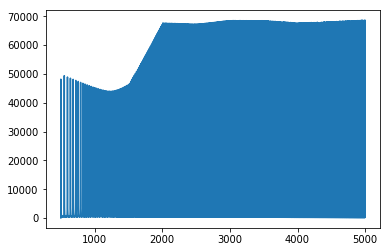

In [5]:
plt.plot(speed_rpm, vibr_gf)
plt.show()

In [6]:
#Vectorised Code
def eval_freqfft_vect(time_sec, vibr):
    datalength_fft = len(time_sec)
    datalengthby2 = int(datalength_fft/2)
    timeavgcalc = np.array([], dtype = float64)
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    timeavgcalc = time_sec_i - time_sec_i_1
    sigint_avg = np.mean(timeavgcalc)
    siginf = 1/(datalength_fft*sigint_avg)
    freqhztemp = np.arange(0,datalength_fft,dtype = float64)
    freqhz = freqhztemp*siginf
    freqhz = freqhz[0:datalengthby2]
    vibr_fft = np.abs(fft(vibr,axis = -1))
    vibr_fft = ((vibr_fft[0:datalengthby2])/datalength_fft)*2
    return freqhz,vibr_fft

In [7]:
def cccum2_vect_func(time_sec, speed_rpm, vibr):
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    speed_rpm_i_1 = speed_rpm[:-1]
    cccum2_vect_temp = (((speed_rpm_i_1/2)/60)*360*(time_sec_i-time_sec_i_1))
    cccum2_vect_temp = np.insert(cccum2_vect_temp,0,0)
    cccum2_vect_temp = np.cumsum(cccum2_vect_temp)
    cycle_vect= np.floor(((cccum2_vect_temp/720.0))+1)
    ccrel2_vect_temp = cccum2_vect_temp-(cycle_vect-1)*720
    maxcy_vect = max(cycle_vect)
    alldata_vect = np.stack((cycle_vect, time_sec, speed_rpm, vibr_gf), axis = 1)
    e, inds = np.unique(alldata_vect[:,0], return_index=True)
    alldata_cycle_vect = np.split(alldata_vect, inds)[1:]
    speedindex = [(np.mean(alldata_cycle_vect[int(j)-1][:,2])) for j in e]
    rms_vibr = [(np.sqrt(np.mean(np.square((alldata_cycle_vect[int(j)-1][:,3]))))) for j in e]
    ampl_vibr = [((max(((alldata_cycle_vect[int(j)-1][:,3])))-min(((alldata_cycle_vect[int(j)-1][:,3]))))/2) for j in e]
    freqhztemp_vibrffttemp = [(eval_freqfft_vect((alldata_cycle_vect[int(j)-1][:,1]), (alldata_cycle_vect[int(j)-1][:,3]))) for j in e]
    freqhztemp = [freqhztemp_vibrffttemp[int(j)-1][0]  for j in e]
    vibrffttemp = [freqhztemp_vibrffttemp[int(j)-1][1]  for j in e]
    freqhz3d = np.array([], dtype = float64)
    vibrfft3d = np.array([], dtype = float64)
    freqhz3d = np.hstack((freqhz3d,freqhztemp))
    vibrfft3d = np.hstack((vibrfft3d,vibrffttemp))
    freqhz3d = freqhz3d[:-1]
    vibrfft3d = vibrfft3d[:-1]
    e_1 = e[:-1]
    freqvibr3d_freq_interptemp = np.array([], dtype = float64)
    freqvibr3d_vibr_interptemp = np.array([], dtype = float64)
    freqvibr3d_vibr_interp = np.array([], dtype = float64)
    funcakimainterp = [(sp.interpolate.Akima1DInterpolator(freqhz3d[int(j)-1], vibrfft3d[int(j)-1])) for j in e_1] 
    tempceilval = int(max(e_1)-1)
    maxfreqval = ((np.around(max(freqhz3d[tempceilval]),decimals=-3)))
    freqvibr3d_freq_interptemp = np.array([np.arange(0, maxfreqval+0.1, 0.1)])
    freqvibr3d_vibr_interptemp = [(funcakimainterp[int(j)-1](freqvibr3d_freq_interptemp)) for j in e_1]
    freqvibr3d_freq_interp = freqvibr3d_freq_interptemp[0]
    freqvibr3d_vibr_interp = [(np.hstack((freqvibr3d_vibr_interp, freqvibr3d_vibr_interptemp[int(j)-1][0]))) for j in e_1]
    #freqvibr3d_vibr_interp = freqvibr3d_vibr_interp[:-1]
    lengrid = len(freqvibr3d_freq_interp)
    

    freq3dx = np.tile(freqvibr3d_freq_interp,(tempceilval+1,1))
    
    freq3dy = np.transpose(np.tile(speedindex[:-1], (lengrid,1)))
    freq3dz = freqvibr3d_vibr_interp

        
    return freq3dx, freq3dy, freq3dz

In [8]:
t1_start = time.perf_counter()
fft3d_vect = cccum2_vect_func(time_sec, speed_rpm, vibr_gf)
t1_end = time.perf_counter()
freq3dx= fft3d_vect[0]
freq3dy= fft3d_vect[1]
freq3dz= fft3d_vect[2]


In [9]:
np.shape(freq3dx),np.shape(freq3dy), np.shape(freq3dz)

((229, 40001), (229, 40001), (229, 40001))

In [10]:
index=int(len(freq3dz))

In [ ]:
[(max(freq3dz[int(j)])) for j in index]

In [ ]:
int(len(freq3dz[0])),max(freq3dz[228])

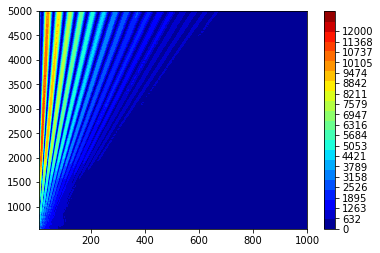

In [11]:
import matplotlib.mlab as griddata

CS = plt.contourf(freq3dx, freq3dy, freq3dz, 25, cmap = plt.cm.jet)

norm = mpl.colors.Normalize(0,12000,20)

barcolors = plt.cm.ScalarMappable(norm, cmap="jet")
bounds = np.linspace(0,12000,20)

plt.colorbar(cmap = "jet", norm=norm, orientation='vertical', spacing = 'proportional', ticks=bounds, boundaries=bounds)
plt.xlim(10,1000)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

surf = ax.plot_surface(np.array(freq3dx), np.array(freq3dy), np.array(freq3dz), rstride=1, cstride=1, cmap=cm.jet)
surf.set_edgecolors(surf.to_rgba(surf._A))

cmap = plt.cm.jet
norm = mpl.colors.Normalize(0,12000)
barcolors = plt.cm.ScalarMappable(norm,cmap)

fig.subplots_adjust(bottom=0.25)
ax1 = fig.add_axes([0.05, 0.1, 0.03, 0.8])
bounds = np.linspace(0,12000,20)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap = cmap, 
                               norm = norm,
                               orientation='vertical', spacing='proportional',
                               ticks = bounds,
                               boundaries=bounds)
plt.xlim(10,1000)
plt.show()

In [ ]:
np.array(freq3dz).ndim

In [ ]:
def cccum2_loop_func(time_sec, speed_rpm, vibr):
    datalength = len(speed_rpm)
    crankanglecum = np.array([0], dtype = float64)
    cccum2_loop = np.array([0], dtype = float64)
    for i in np.arange(1, datalength):
        crankanglecum = np.append(crankanglecum,
                                  (crankanglecum[i-1]+(((speed_rpm[i-1]/2)/60)*360*(time_sec[i]-time_sec[i-1]))))
        cycle = np.array([1], dtype = int)
    crankanglerel = np.array([0], dtype = float64)
    for i in np.arange(1,datalength):
        cycle = (np.append(cycle, np.floor(((crankanglecum[i]/720.0))+1)))
        crankanglerel = np.append(crankanglerel, (crankanglecum[i]-(cycle[i]-1)*720))
    maxcy = max(cycle)
    alldata = np.stack((cycle, time_sec, speed_rpm, vibr), axis = 1)
    e, inds = np.unique(alldata[:,0], return_index=True)
    alldata_cycle = np.split(alldata, inds)[1:]
    speedindex = np.array([], dtype = float64)
    rms_vibr = np.array([], dtype = float64)
    ampl_vibr = np.array([], dtype = float64)
    time_interval = np.array([], dtype = float64)
    freqhz3d = np.array([], dtype = float64)
    vibrfft3d = np.array([], dtype = float64)
    fs = np.array([], dtype = float64)
    for i in np.arange(0,maxcy):
        y = int(i)
        speedindex = (np.append(speedindex,(np.mean(alldata_cycle[y][:,2]))))
        rms_vibr = (np.append(rms_vibr,(np.sqrt(np.mean(np.square((alldata_cycle[y][:,3])))))))
        ampl_vibr = (np.append(ampl_vibr,((max(((alldata_cycle[y][:,3])))-min(((alldata_cycle[y][:,3]))))/2)))
        freqhztemp,vibrtemp = eval_freqfft_vect(alldata_cycle[y][:,1],alldata_cycle[y][:,3])
        freqhz3d = np.hstack((freqhz3d,freqhztemp))
        vibrfft3d = np.hstack((vibrfft3d,vibrtemp))
    return freqhz3d, vibrfft3d

In [ ]:
t2_start = time.perf_counter()
sra_loop_temp = cccum2_loop_func(time_sec, speed_rpm, vibr_gf)
t2_end = time.perf_counter()
freqhz3d_loop = sra_loop_temp[0]
vibrfft3d_loop = sra_loop_temp[1]


In [ ]:
plt.plot(freqhz3d_loop,vibrfft3d_loop)
plt.show()

In [ ]:
t1 = -1*(t1_start - t1_end)
t2 = -1*(t2_start - t2_end)

t1,t2